In [ ]:
from statistics import median

import influxdb_client
import numpy as np
import pandas as pd
from pandas import DataFrame

In [ ]:
TOKEN = '80pzM9UJharBRVfSbBIfecydGJsX80ihx2IZsd7UmAZUhUumZTIiX9jUqQNytXPxeVuZlgLmHAY6JOyHnLZuJw=='
URL = 'http://localhost:8086'
ORG = 'VCT'
BUCKET = 'HOUSE_HOLD_ENERGY'

In [ ]:
client = influxdb_client.InfluxDBClient(url=URL, token=TOKEN, org=ORG,  timeout=30000)

In [ ]:
query_api = client.query_api()

In [ ]:
query = f'''
from(bucket: "{BUCKET}")
  |> range(start: 2007-01-01T00:00:00Z, stop: 2007-12-31T00:00:00Z)
  |> filter(fn: (r) => r["_measurement"] == "house_energy")
  |> filter(fn: (r) => r["_field"] == "Global_active_power" or 
                      r["_field"] == "Global_reactive_power" or 
                      r["_field"] == "Voltage" or 
                      r["_field"] == "Global_intensity" or 
                      r["_field"] == "Sub_metering_1" or 
                      r["_field"] == "Sub_metering_2" or 
                      r["_field"] == "Sub_metering_3")
  |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
'''

In [ ]:
house_hold_energy_2007 = query_api.query_data_frame(query=query)

In [ ]:
house_hold_energy_2007.info()

#### Limpando dataframe

##### Retirando dados desnecessários

In [ ]:
house_hold_energy_2007.head(10)

In [ ]:
house_hold_energy_2007.drop(columns=['result', 'table', '_start', '_stop', '_measurement'], inplace=True)
house_hold_energy_2007.head(10)

In [ ]:
columns_float = list(house_hold_energy_2007.iloc[:, 1:].columns)
columns_float

#### Encontrando dados nulos dados nulos

In [ ]:
rows_null = house_hold_energy_2007.query('Global_active_power == "?"').index
rows_null

In [ ]:
house_hold_energy_2007.iloc[rows_null].head(10)

In [ ]:
house_hold_energy_2007.replace("?", 0.0, inplace=True)
house_hold_energy_2007.iloc[rows_null].head(10)

In [ ]:
house_hold_energy_2007.fillna(0.0, inplace=True)
house_hold_energy_2007.iloc[rows_null].head(10)

In [ ]:
house_hold_energy_2007.interpolate(inplace=True)
house_hold_energy_2007.iloc[rows_null]

#### Convertendo colunas numericas

In [ ]:
house_hold_energy_2007[columns_float] = house_hold_energy_2007[columns_float].astype(float)

In [ ]:
house_hold_energy_2007.info()

#### Adicionando coluna de consumo total (Global_active_power * 1000 / 60 - Sub_metering_1 - Sub_metering_2 - Sub_metering_3)

In [ ]:
house_hold_energy_2007["Energy_consumed"] = house_hold_energy_2007["Global_active_power"] * 1000 / 60 - house_hold_energy_2007["Sub_metering_1"] - house_hold_energy_2007["Sub_metering_2"] - house_hold_energy_2007["Sub_metering_3"]
house_hold_energy_2007.head(10)

#### Renomeando Sub_meterings

In [ ]:
rename_columns = {
    "Sub_metering_1" : "Kitchen",
    "Sub_metering_2" : "Laundry_Room",
    "Sub_metering_3" : "Heater_conditioner"
}

In [ ]:
house_hold_energy_2007.rename(columns=rename_columns, inplace=True)

In [ ]:
house_hold_energy_2007.head(10)

### Analise Exploratoria

#### Dados climaticos da França:
- Primavera: 21 Março até 20 Junho - Temperaturas suaves e dias mais longos
- Verão: 21 Junho até 20 Setembro - Calor, epoca com preços elevados e gande turismo
- Outono: 21 Setembro até 20 Dezembro - Temperatura começa a cair
- Inverno: 21 Dezembro até 20 Março - Frio e neve

#### Dados de consumo
Na França, o consumo médio diário de eletricidade em uma residência varia dependendo de vários fatores, como o tamanho da casa, número de habitantes, uso de equipamentos elétricos, e eficiência energética. Com base no consumo médio anual de 6.249 kWh por habitante em 2007, pode-se estimar o consumo diário de uma casa típica.

##### Perguntas para um dia:
- Quais as trends durante o dia?
- Qual a media do consumo?
- Qual a mediana do consumo?
- Qual o desvio padrao do consumo?
- Quais os valores minimos do dia?
- Quail o padrao de consumo durante 1 dia?

#### Analisando dias da semana de Janeiro


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
jan_energy = house_hold_energy_2007[house_hold_energy_2007["_time"].dt.month == 1]
jan_energy

In [ ]:
def get_statistics(data: DataFrame) -> dict:
    return {
        "mean": data['Energy_consumed'].mean().round(decimals=2),
        "median": data['Energy_consumed'].median().round(decimals=2),
        "std": data['Energy_consumed'].std().round(decimals=2),
        "max": data['Energy_consumed'].max().round(decimals=2),
        "min": data['Energy_consumed'].min().round(decimals=2),
        "sum": data['Energy_consumed'].sum().round(decimals=2)
    }

##### Funcao para imprimir estatisticas de um dataframe

In [ ]:
def print_statistics(data: DataFrame):
    statistics = get_statistics(data)
    print(f"Dia {data['_time'].dt.date[0]} {data['_time'].dt.day_name()[0]}")
    print(f"Media: {statistics['mean']}")
    print(f"Mediana: {statistics['median']}")
    print(f"Desvio padrao: {statistics['std']}")
    print(f"Consumo maximo: {statistics['max']}")
    print(f"Consumo minimo: {statistics['min']}")
    print(f"Consumo total: {statistics['sum']}")
    print()

##### Funcao para plotar lines com todas os dados de um determinado dia da semana de um mes

In [ ]:
def plot_lines_energy_consume(month_df : DataFrame, day_of_week : int, day : str):
    day_week_df = month_df[month_df["_time"].dt.dayofweek == day_of_week][["_time", "Energy_consumed"]]
    day_start = pd.to_datetime(day).date()
    for i in range(4):
        day_stop = (day_start + pd.DateOffset(days=6)).date()
        if day_start.month == month_df['_time'].dt.month[0]:
            day_df = day_week_df[(day_week_df["_time"].dt.date >= day_start) & (day_week_df["_time"].dt.date <= day_stop)].reset_index(drop=True)
            day_df.plot(kind="line", x="_time", y="Energy_consumed", figsize=(20,5), title=day_df['_time'].dt.date[0])
            day_start = day_stop
    plt.show()

##### Funcao para imprimir todas os dados estatisticos de um determinado dia da semana de um mes

In [ ]:
def print_statistics_day_week_consume(month_df : DataFrame, day_of_week : int, day : str):
    day_week_df = month_df[month_df["_time"].dt.dayofweek == day_of_week][["_time", "Energy_consumed"]]
    day_start = pd.to_datetime(day).date()
    for i in range(4):
        day_stop = (day_start + pd.DateOffset(days=6)).date()
        if day_start.month == month_df['_time'].dt.month[0]:
            day_df = day_week_df[(day_week_df["_time"].dt.date >= day_start) & (day_week_df["_time"].dt.date <= day_stop)].reset_index(drop=True)
            print_statistics(day_df)
        day_start = day_stop

In [171]:
def print_agg_statics_day_week_consume(statistics_dict: dict):
    mean_total = np.mean([values['mean'] for values in statistics_dict.values()])
    median_total = np.median([values['median'] for values in statistics_dict.values()])
    std_total = np.std([values['std'] for values in statistics_dict.values()])
    max_total = max([values['max'] for values in statistics_dict.values()])
    min_total = min([values['min'] for values in statistics_dict.values()])
    sum_total = sum([values['sum'] for values in statistics_dict.values()])
    print(f"Mediana {median_total}")
    print(f"Max {max_total}")
    print(f"Min {min_total}")
    print(f"Std {std_total}")
    print(f"Media {mean_total.round(decimals=2)}")
    print(f"Sum {sum_total}")

In [ ]:
from collections import defaultdict
from pandas import DataFrame
import numpy as np

##### Funcao para retornar dados estatisticos de um determinado dia da semana de um mes

In [ ]:
def get_statistics_day_week_consume(month_df : DataFrame, day_of_week : int, day : str) -> defaultdict:
    statistics = defaultdict(pd.DataFrame)
    day_week_df = month_df[month_df["_time"].dt.dayofweek == day_of_week][["_time", "Energy_consumed"]]
    day_start = pd.to_datetime(day).date()
    for i in range(4):
        day_stop = (day_start + pd.DateOffset(days=6)).date()
        if day_start.month == month_df['_time'].dt.month[0]:
            day_df = day_week_df[(day_week_df["_time"].dt.date >= day_start) & (day_week_df["_time"].dt.date <= day_stop)].reset_index(drop=True)
            statistics[i] = get_statistics(day_df)
        day_start = day_stop
    return statistics

##### Funcao para plotar boxplot com todas os dados de um determinado dia da semana de um mes

In [ ]:
def plot_box_energy_consume(month_df : DataFrame, day_of_week : int, day : str):
    day_week_df = month_df[month_df["_time"].dt.dayofweek == day_of_week][["_time", "Energy_consumed"]]
    day_start = pd.to_datetime(day).date()
    for i in range(4):
        day_stop = (day_start + pd.DateOffset(days=6)).date()
        if day_start.month == month_df['_time'].dt.month[0]:
            week_df = day_week_df[(day_week_df["_time"].dt.date >= day_start) & (day_week_df["_time"].dt.date <= day_stop)]
            week_df.plot(kind="box", x="_time", y="Energy_consumed", figsize=(20,5))
            day_start = day_stop
    plt.show()

- Segundas

In [ ]:
plot_lines_energy_consume(jan_energy, 0, '2007-01-01')

##### Verificando outliers, mediana, simetria e dispersao com boxplot

In [ ]:
plot_box_energy_consume(jan_energy, 0, '2007-01-01')

##### Verificando dados estatisticos das segundas de cada semana de Janeiro

In [172]:
# Dados por dia
print_statistics_day_week_consume(jan_energy, 0, '2007-01-01')

Dia 2007-01-01 Monday
Media: 27.49
Mediana: 39.9
Desvio padrao: 16.9
Consumo maximo: 50.27
Consumo minimo: 2.67
Consumo total: 39584.73

Dia 2007-01-08 Monday
Media: 13.43
Mediana: 7.65
Desvio padrao: 12.13
Consumo maximo: 69.23
Consumo minimo: 2.13
Consumo total: 19342.0

Dia 2007-01-15 Monday
Media: 12.02
Mediana: 6.43
Desvio padrao: 11.4
Consumo maximo: 71.33
Consumo minimo: 1.33
Consumo total: 17310.3

Dia 2007-01-22 Monday
Media: 14.54
Mediana: 6.02
Desvio padrao: 13.86
Consumo maximo: 103.53
Consumo minimo: 1.77
Consumo total: 20943.57



In [173]:
# Dados por dia agregados
statistics = get_statistics_day_week_consume(jan_energy, 0, '2007-01-01')
print("Segundas de Janeiro")
print_agg_statics_day_week_consume(statistics)

Segundas de Janeiro
Mediana 7.04
Max 103.53
Min 1.33
Std 2.1186950582846973
Media 16.87
Sum 97180.6


- Tercas

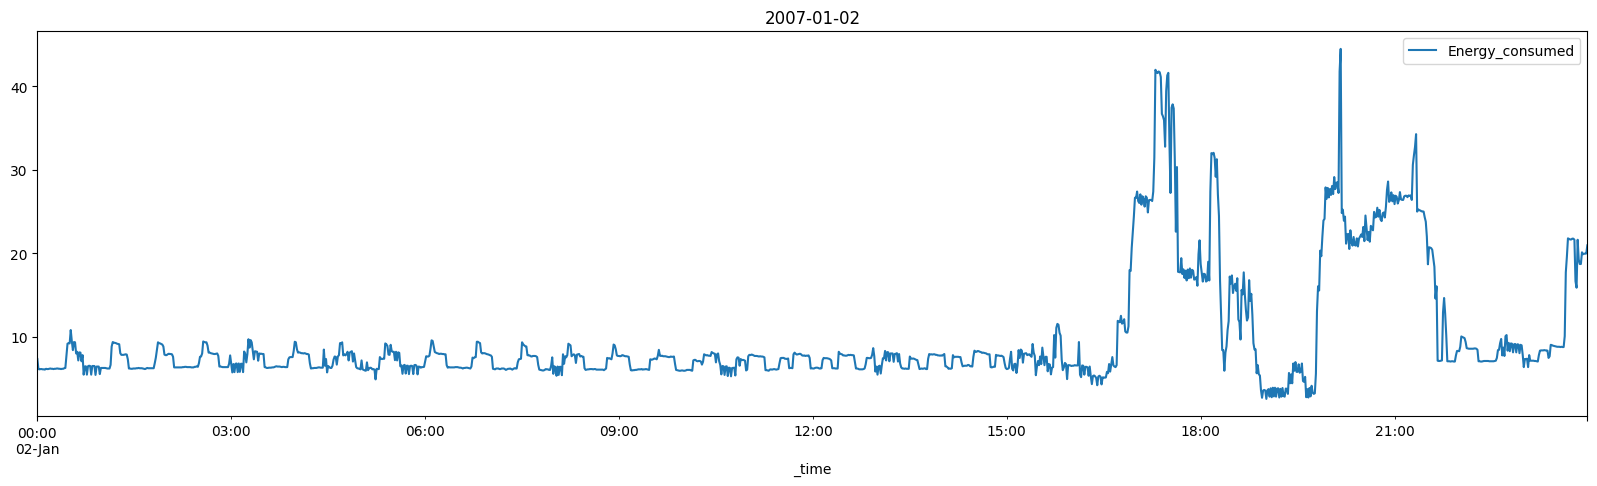

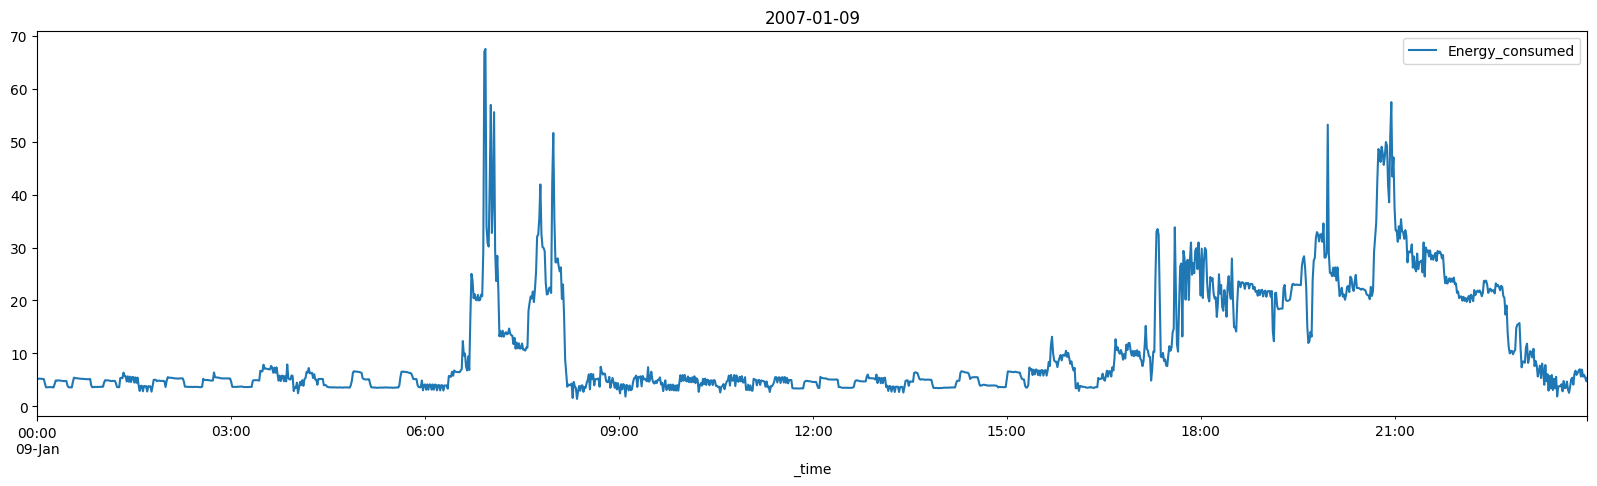

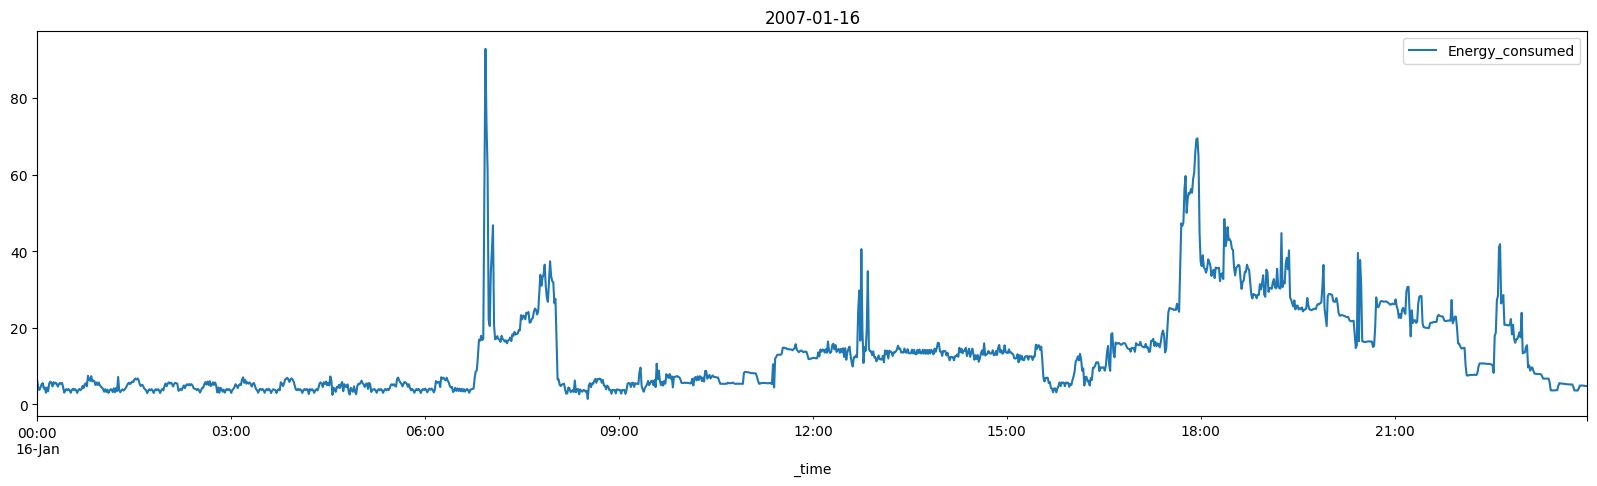

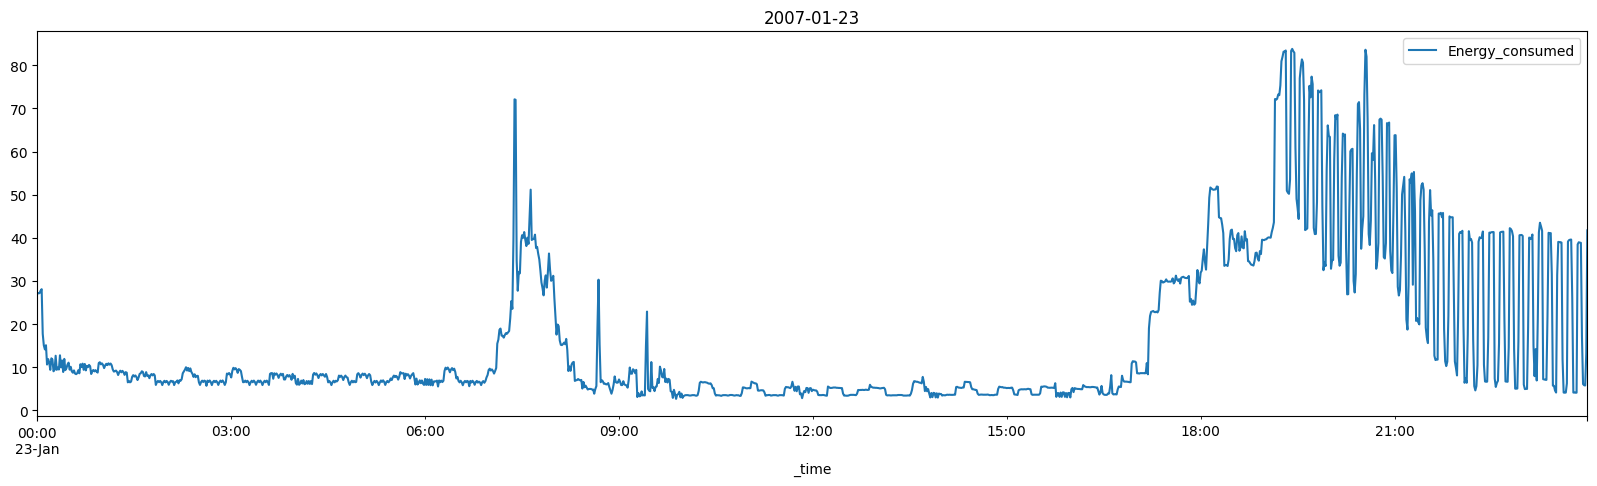

In [174]:
plot_lines_energy_consume(jan_energy, 1, '2007-01-02')

##### Verificando outliers, mediana, simetria e dispersao com boxplot

In [ ]:
plot_box_energy_consume(jan_energy, 1, '2007-01-02')

##### Verificando dados estatisticos das terças da semana

In [175]:
# Dados por dia
print_statistics_day_week_consume(jan_energy, 1, '2007-01-02')

Dia 2007-01-02 Tuesday
Media: 9.89
Mediana: 7.5
Desvio padrao: 6.87
Consumo maximo: 44.47
Consumo minimo: 2.6
Consumo total: 14243.93

Dia 2007-01-09 Tuesday
Media: 10.7
Mediana: 5.4
Desvio padrao: 10.02
Consumo maximo: 67.57
Consumo minimo: 1.4
Consumo total: 15405.9

Dia 2007-01-16 Tuesday
Media: 13.07
Mediana: 9.55
Desvio padrao: 11.04
Consumo maximo: 92.83
Consumo minimo: 1.37
Consumo total: 18816.73

Dia 2007-01-23 Tuesday
Media: 16.32
Mediana: 7.23
Desvio padrao: 17.87
Consumo maximo: 83.8
Consumo minimo: 2.67
Consumo total: 23502.33



In [176]:
# Dados por dia agregados
statistics = get_statistics_day_week_consume(jan_energy, 1, '2007-01-02')
print("Terças de Janeiro")
print_agg_statics_day_week_consume(statistics)

Terças de Janeiro
Mediana 7.365
Max 92.83
Min 1.37
Std 4.0126612117147396
Media 12.5
Sum 71968.89


- Quartas

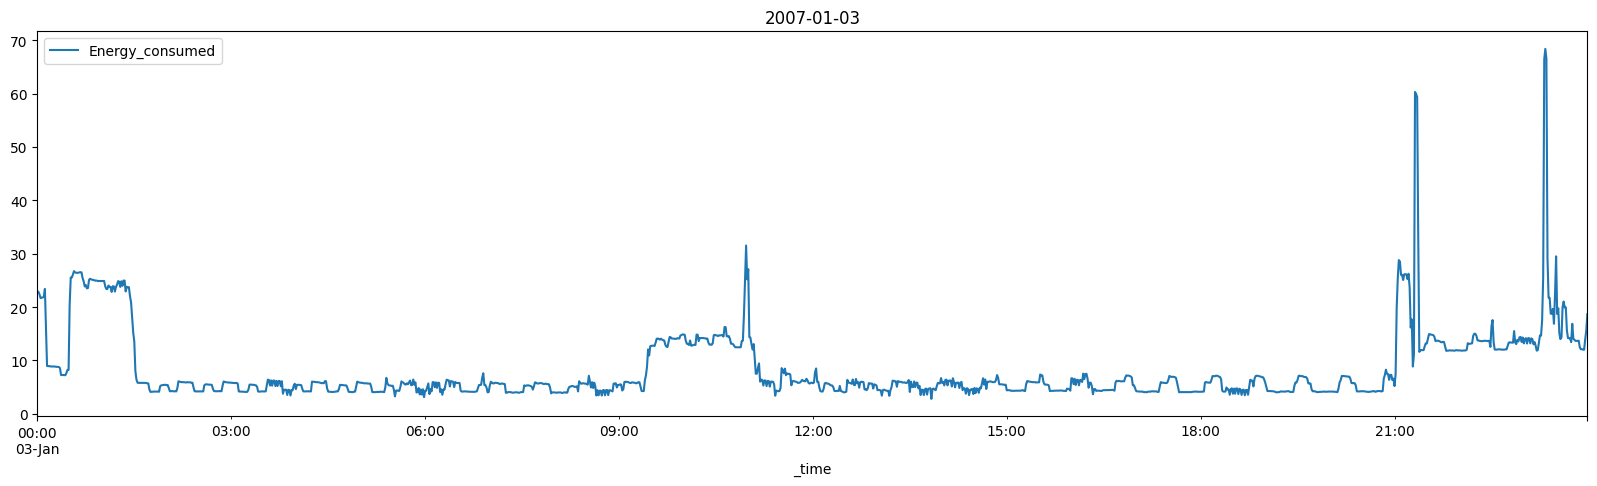

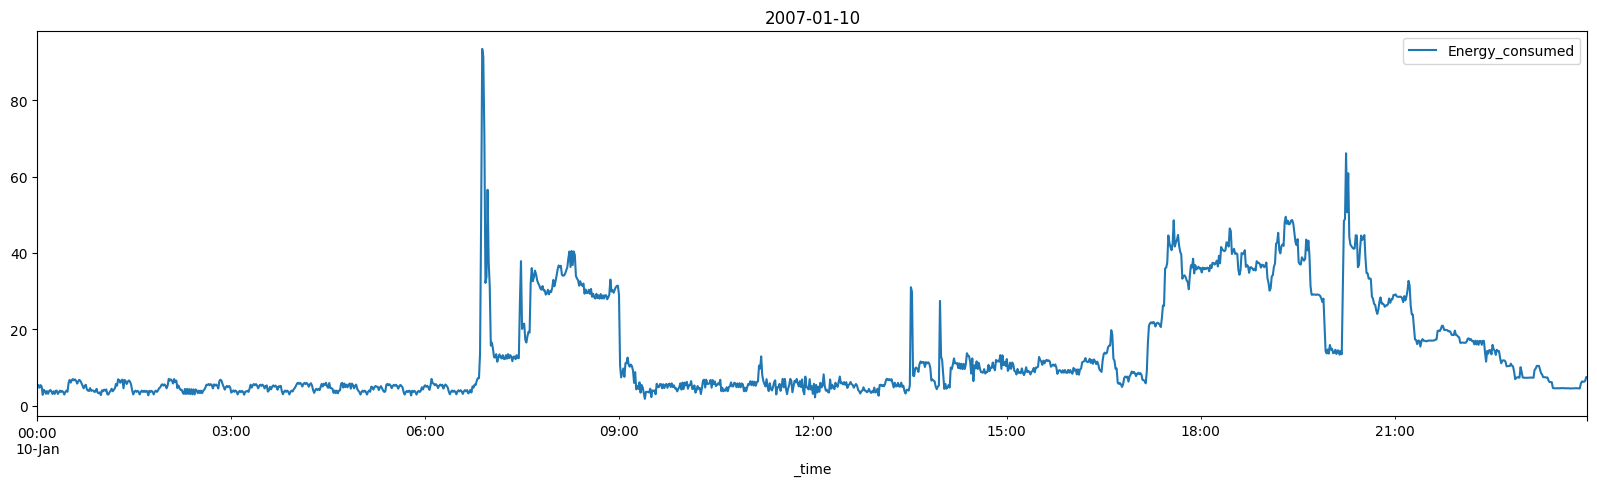

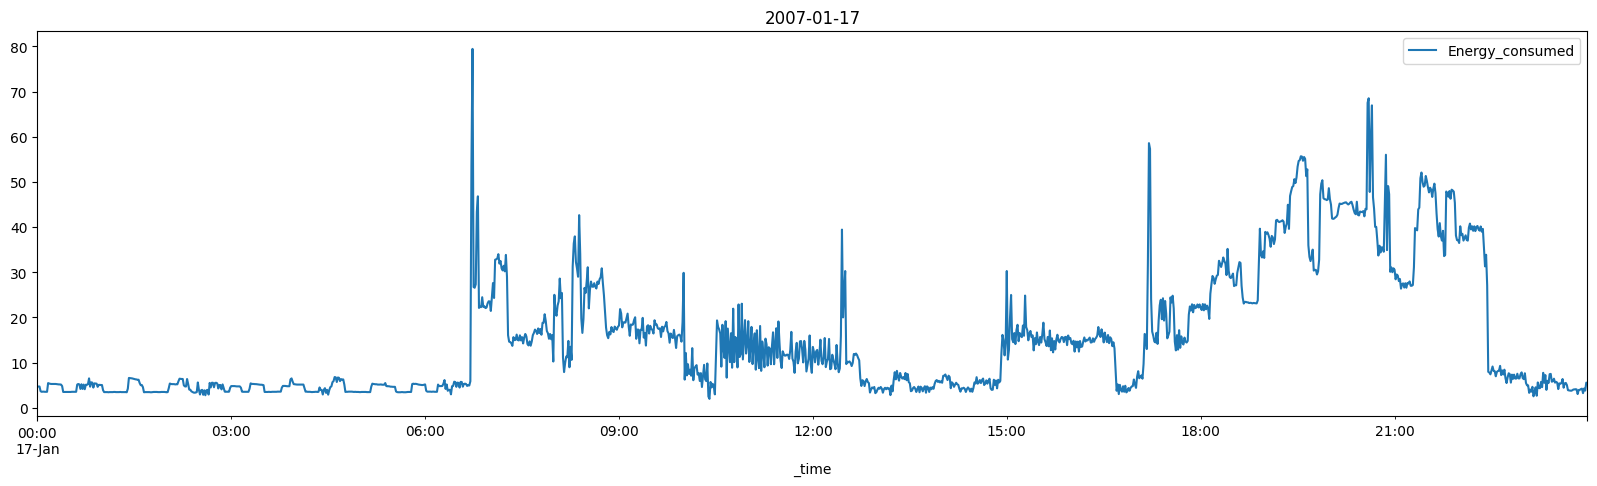

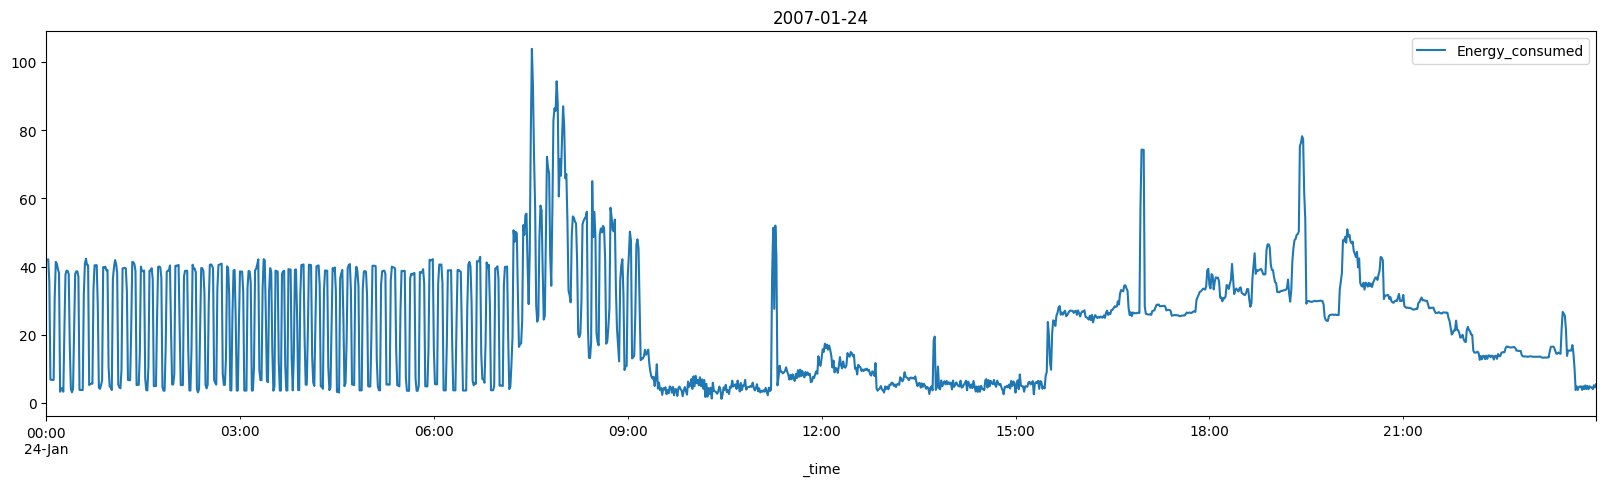

In [177]:
plot_lines_energy_consume(jan_energy, 2, '2007-01-03')

##### Verificando outliers, mediana, simetria e dispersao com boxplot

In [ ]:
plot_box_energy_consume(jan_energy, 2, '2007-01-03')

#### Verificando valores estatisticos das quartas de Janeiro

In [178]:
# Dados por dia
print_statistics_day_week_consume(jan_energy, 2, '2007-01-03')

Dia 2007-01-03 Wednesday
Media: 8.19
Mediana: 5.77
Desvio padrao: 6.62
Consumo maximo: 68.37
Consumo minimo: 2.8
Consumo total: 11791.9

Dia 2007-01-10 Wednesday
Media: 13.66
Mediana: 7.12
Desvio padrao: 12.88
Consumo maximo: 93.5
Consumo minimo: 1.77
Consumo total: 19674.33

Dia 2007-01-17 Wednesday
Media: 15.39
Mediana: 10.08
Desvio padrao: 13.68
Consumo maximo: 79.43
Consumo minimo: 1.97
Consumo total: 22160.47

Dia 2007-01-24 Wednesday
Media: 22.3
Mediana: 21.38
Desvio padrao: 16.67
Consumo maximo: 103.8
Consumo minimo: 1.2
Consumo total: 32109.57



In [179]:
# Dados por dia agregados
statistics = get_statistics_day_week_consume(jan_energy, 2, '2007-01-03')
print("Quartas de Janeiro")
print_agg_statics_day_week_consume(statistics)

Quartas de Janeiro
Mediana 8.6
Max 103.8
Min 1.2
Std 3.6569958640939157
Media 14.89
Sum 85736.27


- Quintas

In [ ]:
plot_lines_energy_consume(jan_energy, 4, '2007-01-05')

##### Verificando outliers, mediana, simetria e dispersao com boxplot

In [ ]:
plot_box_energy_consume(jan_energy, 4, '2007-01-05')

- Sextas

In [ ]:
plot_lines_energy_consume(jan_energy, 5, '2007-01-06')

##### Verificando outliers, mediana, simetria e dispersao com boxplot

In [ ]:
plot_box_energy_consume(jan_energy, 5, '2007-01-06')

- Sabados

In [ ]:
plot_lines_energy_consume(jan_energy, 6, '2007-01-07')

##### Verificando outliers, mediana, simetria e dispersao com boxplot

In [ ]:
plot_box_energy_consume(jan_energy, 6, '2007-01-07')

- Domingos

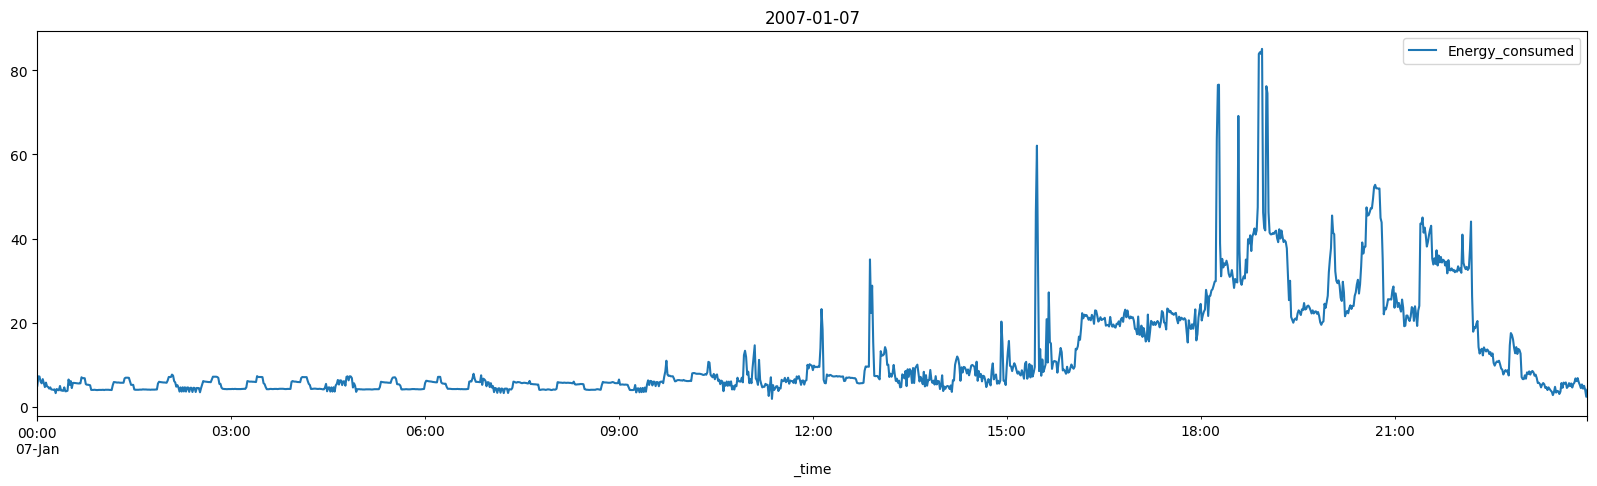

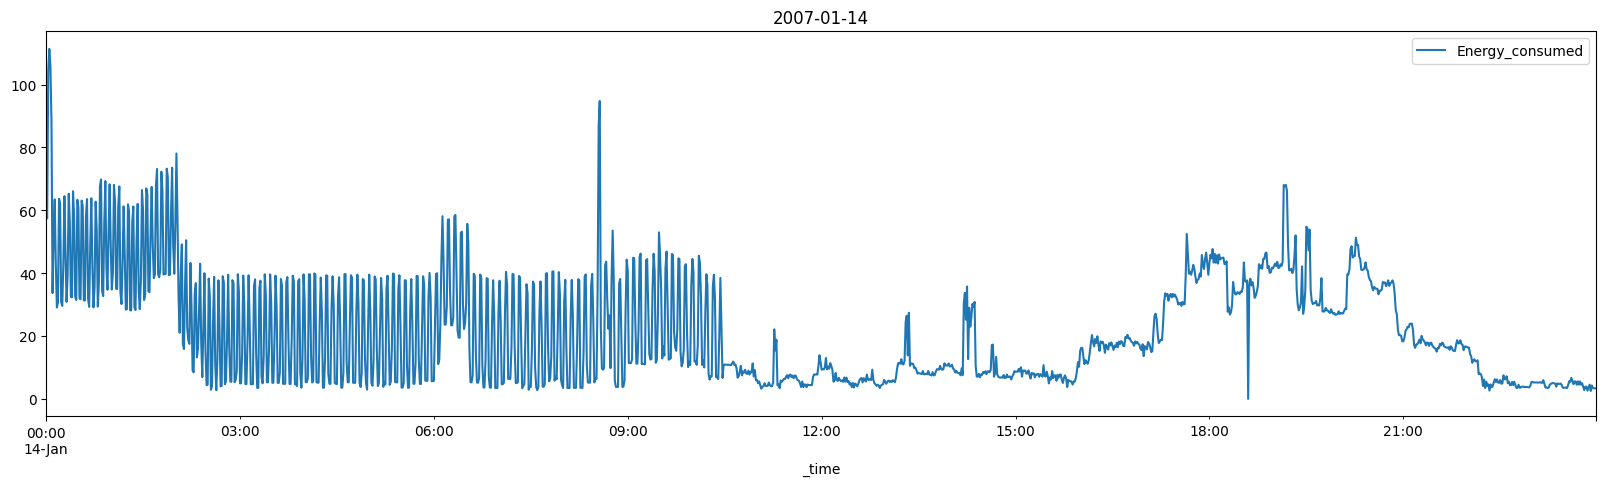

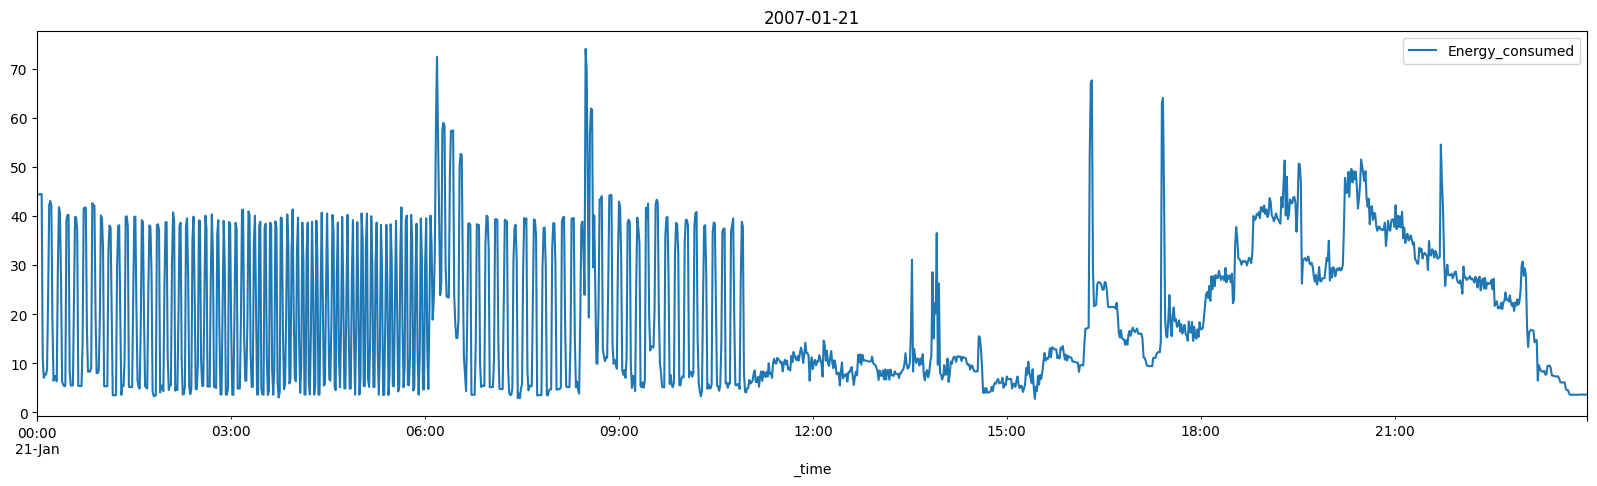

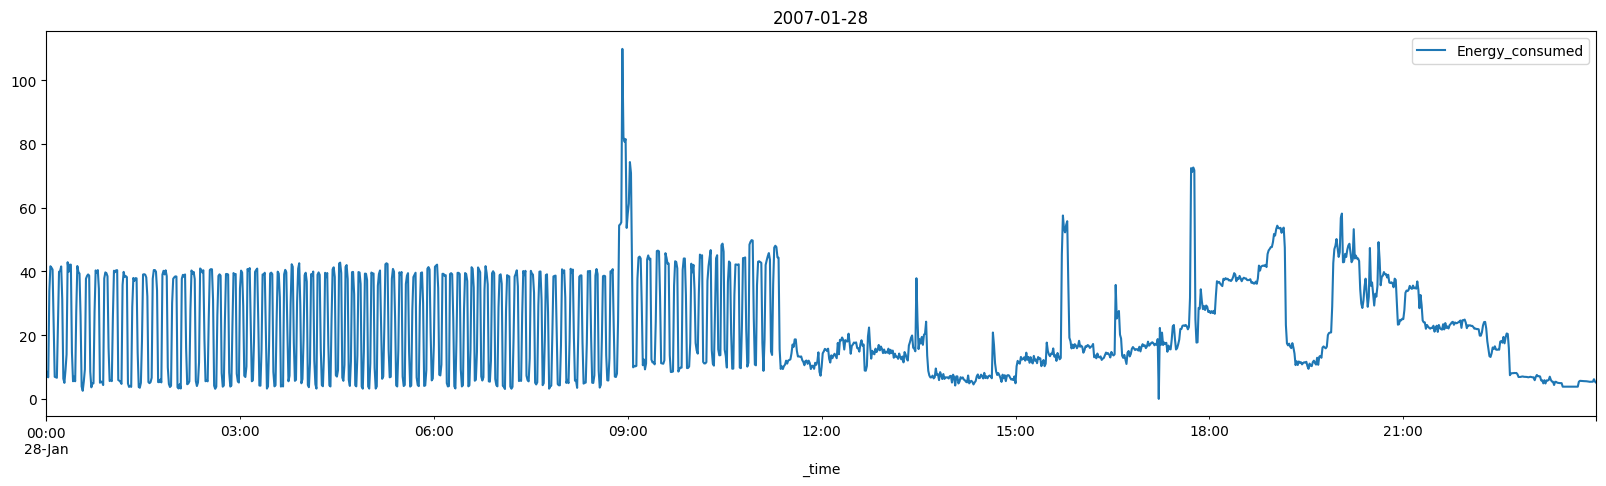

In [163]:
plot_lines_energy_consume(jan_energy, 6, '2007-01-07')

In [164]:
print_statistics_day_week_consume(jan_energy, 6, '2007-01-07')

Dia 2007-01-07 Sunday
Media: 12.37
Mediana: 6.57
Desvio padrao: 12.05
Consumo maximo: 85.07
Consumo minimo: 1.9
Consumo total: 17819.67

Dia 2007-01-14 Sunday
Media: 21.64
Mediana: 16.5
Desvio padrao: 17.38
Consumo maximo: 111.33
Consumo minimo: 0.0
Consumo total: 31163.27

Dia 2007-01-21 Sunday
Media: 20.33
Mediana: 16.0
Desvio padrao: 14.48
Consumo maximo: 74.0
Consumo minimo: 2.73
Consumo total: 29275.7

Dia 2007-01-28 Sunday
Media: 22.22
Mediana: 17.17
Desvio padrao: 15.24
Consumo maximo: 109.87
Consumo minimo: 0.0
Consumo total: 31995.4



In [ ]:
# Dados por dia agregados
statistics = get_statistics_day_week_consume(jan_energy, 6, '2007-01-07')
mean_total = np.mean([values['mean'] for values in statistics.values()])
median_total = np.median([values['median'] for values in statistics.values()])
std_total = sum([values['std'] for values in statistics.values()])
max_total = max([values['max'] for values in statistics.values()])
min_total = min([values['min'] for values in statistics.values()])
sum_total = sum([values['sum'] for values in statistics.values()])
print("Segundas de Janeiro")
print(f"Mediana {median_total}")
print(f"Max {max_total}")
print(f"Min {min_total}")
print(f"Std {std_total}")
print(f"Media {mean_total.round(decimals=2)}")
print(f"Sum {sum_total}")

#### Fevereiro

- Segundas

#### Script para gerar graficos mensais